In [5]:
import numpy as np
import cv2
from pyproj import Transformer
from my_vbr_utils.vbr_dataset import VBRDataset, load_scene_calibration
from my_vbr_utils.utilities import load_scene_correspondences

# --- Config and Dataset Loading ---
# Set these variables to configure your scene and utility path
location = 'ciampino'
vbr_utils_root = '/home/bjangley/VPR/mast3r-v2/my_vbr_utils'

config_path = f'{vbr_utils_root}/vbrPaths.yaml'

# Load dataset and calibration
all_loaded = VBRDataset(config_path, locations=[location])
vbr_scene = all_loaded.get_combined_dataset()
calib = load_scene_calibration(location, config_path)


Loading scene: ciampino_train0
  KITTI path: /datasets/vbr_slam/ciampino/ciampino_train0_kitti
  GT path: /datasets/vbr_slam/ciampino/ciampino_train0/ciampino_train0_gt.txt
  ✓ Successfully loaded ciampino_train0
Loading scene: ciampino_train1
  KITTI path: /datasets/vbr_slam/ciampino/ciampino_train1_kitti
  GT path: /datasets/vbr_slam/ciampino/ciampino_train1/ciampino_train1_gt.txt
  ✓ Successfully loaded ciampino_train1
Loaded 2 training scenes: ['ciampino_train0', 'ciampino_train1']


In [6]:
vbr_scene_traj = vbr_scene.get_local_trajectory()

In [7]:
info = vbr_scene.get_dataset_info()
print(info)
trajs = [[x['start_index'],x['end_index']] for x in info]
print(trajs)

[{'dataset_index': 0, 'length': 30985, 'start_index': 0, 'end_index': 30984}, {'dataset_index': 1, 'length': 18847, 'start_index': 30985, 'end_index': 49831}]
[[0, 30984], [30985, 49831]]


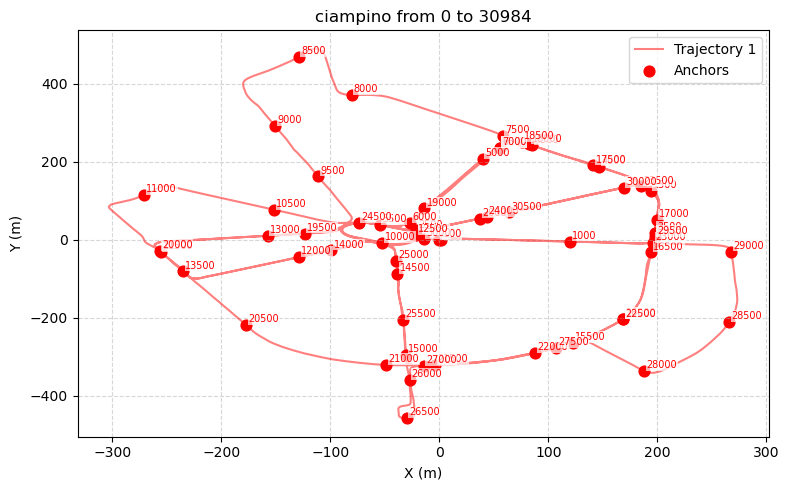

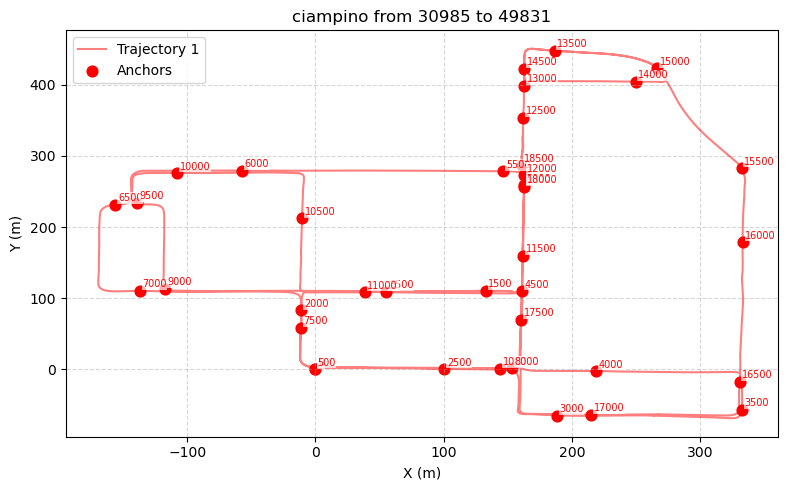

In [8]:
import matplotlib.pyplot as plt
import numpy as np
n = 500 #step 
for start,end in trajs:
    x1, y1 = vbr_scene_traj[start:end, 0], vbr_scene_traj[start:end, 1]
    indices = np.arange(0,len(x1),n)
    plt.figure(figsize=(8, 5))
    plt.plot(x1, y1, 'r-', alpha=0.5, label='Trajectory 1')

    # Scatter anchor and query markers
    plt.scatter(x1[indices], y1[indices], color='red', marker='o', s=60, label='Anchors')

    # Annotate each anchor and query with its index (with offset and background)
    for idx in indices:
        plt.text(x1[idx] + 2, y1[idx] + 2, str(idx), color='red', fontsize=7,
                 ha='left', va='bottom',
                 bbox=dict(facecolor='white', edgecolor='none', alpha=0.7, pad=0.5))

    plt.xlabel('X (m)')
    plt.ylabel('Y (m)')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.title(f"{location} from {start} to {end}")
    plt.tight_layout()
    plt.show()



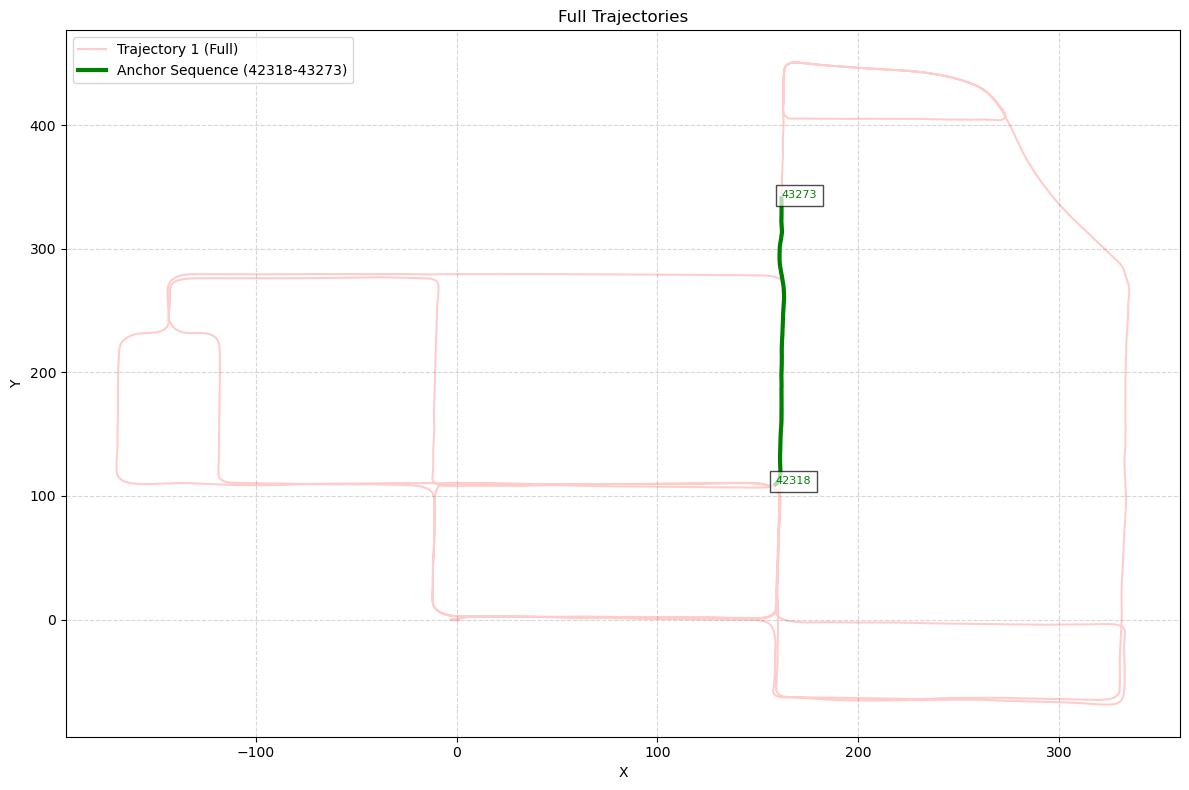

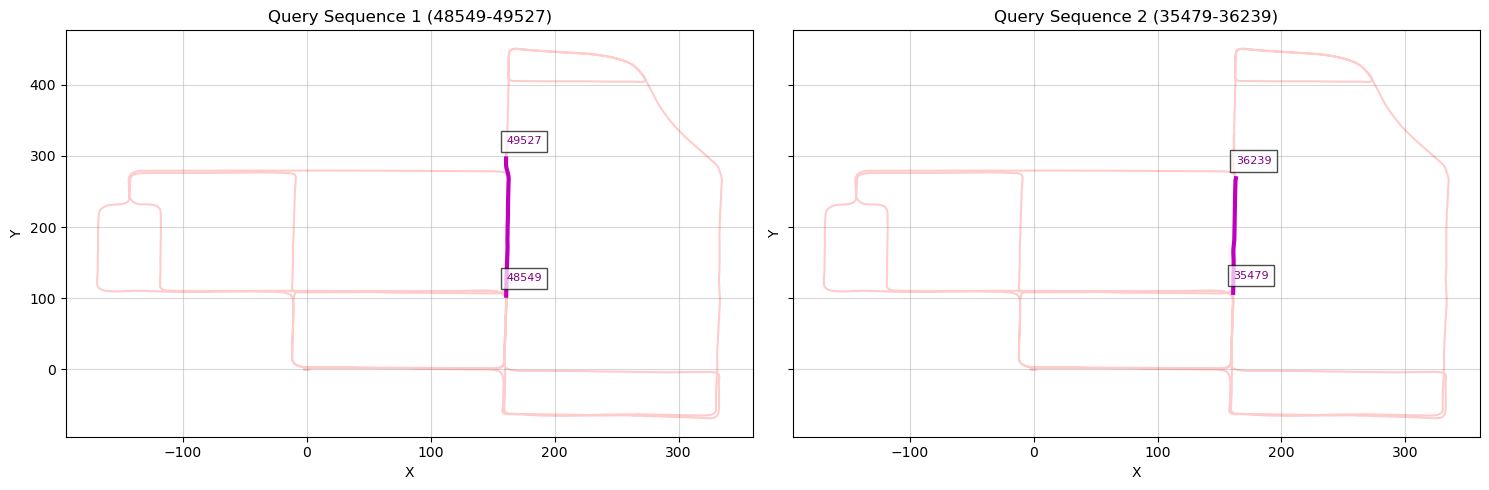

In [37]:
import matplotlib.pyplot as plt
import numpy as np

anchor_query_dict = {
    (30985, 33229): [
        [33229, 33627],
        [35205, 35478],
        [38330, 39041],
        [41800, 42255],
        [48349, 48548]
    ],
    (33653, 34656): [
        [47465, 48347]
    ],
    (42318, 43273): [
        [48549, 49527],
        [35479, 36239]
    ],
    (36857, 37364): [
        [40556, 41243]
    ],
    (38015, 38262): [
        [39704, 39981]
    ],
    (44085, 44835): [
        [45443, 46051]
    ]
}


anchor_range = (42318, 43273)
trajs=[[0, 30984], [30985, 49831]]
# Find which section of trajs the anchor_range falls under
def find_traj_section(anchor_range, trajs):
    for i, (start, end) in enumerate(trajs):
        if anchor_range[0] >= start and anchor_range[1] <= end:
            return i, start, end
    return None, None, None

section_idx, start, end  = find_traj_section(anchor_range, trajs)
query_ranges = anchor_query_dict[anchor_range]

# Extract anchor and query chunks
anchor_sequence = [vbr_scene_traj[anchor_range[0]:anchor_range[1], :]]
query_sequence = [vbr_scene_traj[start_q:end_q,:] for start_q, end_q in query_ranges]

x1, y1 = vbr_scene_traj[start:end,0], vbr_scene_traj[start:end,1]
# Plot full trajectories for context
plt.figure(figsize=(12, 8))
plt.plot(x1, y1, 'r-', label='Trajectory 1 (Full)', alpha=0.2)  # Full trajectory 1

# Overlay anchor chunks
for chunk in anchor_sequence:
    plt.plot(chunk[:, 0], chunk[:, 1], 'g-', label=f'Anchor Sequence ({anchor_range[0]}-{anchor_range[1]})', linewidth=3)
    plt.text(chunk[0, 0], chunk[0, 1], f"{anchor_range[0]}", color='green', fontsize=8, bbox=dict(facecolor='white', alpha=0.7))
    plt.text(chunk[-1, 0], chunk[-1, 1], f"{anchor_range[1]}", color='green', fontsize=8, bbox=dict(facecolor='white', alpha=0.7))

plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.title("Full Trajectories")
plt.tight_layout()
plt.show()

# Create subplots for query sequences
num_queries = len(query_ranges)
cols = 2  # Number of columns for subplots
rows = (num_queries + cols - 1) // cols  # Calculate rows dynamically
fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows), sharex=True, sharey=True)
axes = axes.flatten()  # Flatten axes for easy indexing

# Plot each query sequence in its own subplot
for i, (query_sequence, (start, end)) in enumerate(zip(query_sequence, query_ranges)):
    axes[i].plot(x1, y1, 'r-', label='Trajectory 1 (Full)', alpha=0.2)  # Full trajectory for context
    axes[i].plot(query_sequence[:, 0], query_sequence[:, 1], 'm-', linewidth=3, label=f'Query ({start}-{end})')
    axes[i].text(query_sequence[0, 0], query_sequence[0, 1]+20, f"{start}", color='purple', fontsize=8,
                 bbox=dict(facecolor='white', alpha=0.7))
    axes[i].text(query_sequence[-1, 0], query_sequence[-1, 1]+20, f"{end}", color='purple', fontsize=8,
                 bbox=dict(facecolor='white', alpha=0.7))
    axes[i].set_title(f"Query Sequence {i+1} ({start}-{end})")
    axes[i].set_xlabel("X")
    axes[i].set_ylabel("Y")
    axes[i].grid(True, linestyle='-', alpha=0.5)
    # axes[i].legend()

# Hide unused subplots
for j in range(num_queries, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

In [18]:
anchor_query_dict = {(0, 2000): [[6000, 7200], [20000, 21300]], 
               (8000, 10000): [[21400, 24000],[7400, 8000], [10000, 11000], [38700, 39200],[2000,2400]], 
               (39300, 42434): [[2500, 6000]], 
               (27000, 30200): [[14000,15000],[30200,31000]]}

In [23]:
import json
json_path = "/home/bjangley/VPR/mast3r-v2/my_vbr_utils/vbr_sequences/campus.json"
def load_anchor_query_dict(json_file_path):
    """
    Load the anchor-query dictionary from a JSON file.
    """
    with open(json_file_path, 'r') as f:
        loaded_dict = json.load(f)

    # Convert string keys back to tuples
    anchor_query_dict = {tuple(map(int, key.strip("()").split(","))): value for key, value in loaded_dict.items()}
    return anchor_query_dict
def calculate_total_queries(anchor_query_dict, step_size):
    """
    Calculates the total number of query sequences after subsampling with a given step size.

    Args:
        anchor_query_dict (dict): A dictionary where keys are anchor ranges (tuples) and
                                   values are lists of query ranges (lists of tuples).
        step_size (int): The step size for subsampling the query ranges.

    Returns:
        int: The total number of query sequences after subsampling.
    """
    total_queries = 0
    for anchor_range, query_ranges in anchor_query_dict.items():
        for query_range in query_ranges:
            start, end = query_range
            # Calculate the number of subsampled queries for this range
            num_queries = (end - start + step_size - 1) // step_size  # Ceiling division
            total_queries += num_queries
    return total_queries

# Example usage:
step_size =20  # Example step size
anchor_query_dict=load_anchor_query_dict(json_path)
total_queries = calculate_total_queries(anchor_query_dict, step_size)
print(f"Total number of query sequences after subsampling with step size {step_size}: {total_queries}")

Total number of query sequences after subsampling with step size 20: 537
